In [1]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Sequential
from keras.models import load_model
from keras.models import Model
from keras.layers import Dense
from keras.layers.merge import concatenate

from matplotlib import pyplot
from os import makedirs
from numpy import dstack
from numpy import argmax
from numpy import array
from numpy import mean
from numpy import std
import numpy
from numpy import tensordot
from numpy.linalg import norm
from itertools import product

### Based Line 

Train: 0.810, Test: 0.812


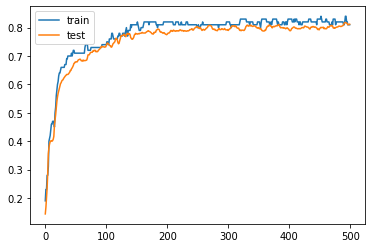

In [2]:
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
y = to_categorical(y)

n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

### Model Averaging

In [6]:
def FitModel(X_train, y_train, X_test, y_test):
  model = Sequential()
  model.add(Dense(25, input_dim=2, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  model.fit(X_train, y_train, epochs=500, verbose=0)
  _, test_acc = model.evaluate(X_test, y_test, verbose=0)

  return test_acc

> Score: 0.8199999928474426
> Score: 0.8171428442001343
> Score: 0.822857141494751
> Score: 0.8114285469055176
> Score: 0.8171428442001343
> Score: 0.8171428442001343
> Score: 0.8171428442001343
> Score: 0.8142856955528259
> Score: 0.8171428442001343
> Score: 0.8199999928474426
> Score: 0.8199999928474426
> Score: 0.808571457862854
> Score: 0.8257142901420593
> Score: 0.8171428442001343
> Score: 0.8142856955528259
> Score: 0.8114285469055176
> Score: 0.8142856955528259
> Score: 0.822857141494751
> Score: 0.8142856955528259
> Score: 0.8171428442001343
> Score: 0.8199999928474426
> Score: 0.822857141494751
> Score: 0.8142856955528259
> Score: 0.8114285469055176
> Score: 0.8171428442001343
> Score: 0.822857141494751
> Score: 0.8199999928474426
> Score: 0.8199999928474426
> Score: 0.8142856955528259
> Score: 0.8171428442001343
Scores Mean: 0.817333322763443 Standard Deviation: 0.003968130636704102


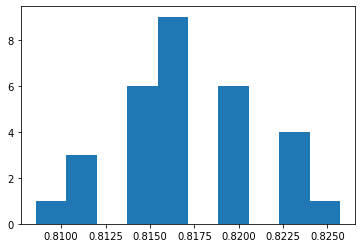

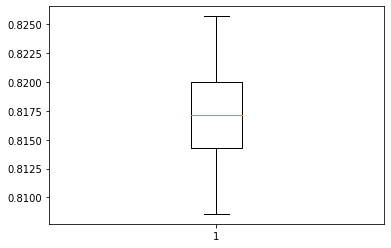

In [7]:
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)
y_encoded = to_categorical(y)
n_train = int(0.3 * X.shape[0])
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y_encoded[:n_train], y_encoded[n_train:]

n_repeats = 30
scores = []

for _ in range(n_repeats):
	score = FitModel(X_train, y_train, X_test, y_test)
	print(f'> Score: {score}')
	scores.append(score)

print(f'Scores Mean: {mean(scores)} Standard Deviation: {std(scores)}')

pyplot.hist(scores, bins=10)
pyplot.show()
pyplot.boxplot(scores)
pyplot.show()

### Model Averaging Ensemble

In [8]:
def FitModel(X_train, y_train):
  y_train_encoded = to_categorical(y_train)

  model = Sequential()
  model.add(Dense(25, input_dim=2, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  model.fit(X_train, y_train_encoded, epochs=500, verbose=0)

  return model

In [9]:
def EnsemblePredictions(models, X_test):
  prediction = [model.predict(X_test) for model in models]
  prediction = array(prediction)
  summed = numpy.sum(prediction, axis=0)
  result = argmax(summed, axis=1)

  return result

In [10]:
def EvaluateModels(models, n_members, X_test, y_test):
  subset = models[:n_members]
  prediction = EnsemblePredictions(subset, X_test)
  accuracy = accuracy_score(y_test, prediction)

  return accuracy

> 1: Single: 0.8040000200271606, Ensemble: 0.804
> 2: Single: 0.8119999766349792, Ensemble: 0.805
> 3: Single: 0.8130000233650208, Ensemble: 0.809
> 4: Single: 0.8130000233650208, Ensemble: 0.809
> 5: Single: 0.8119999766349792, Ensemble: 0.809
> 6: Single: 0.8140000104904175, Ensemble: 0.811
> 7: Single: 0.8069999814033508, Ensemble: 0.808
> 8: Single: 0.8040000200271606, Ensemble: 0.81
> 9: Single: 0.8040000200271606, Ensemble: 0.81
> 10: Single: 0.8040000200271606, Ensemble: 0.81
Accuracy 0.809 (0.004)


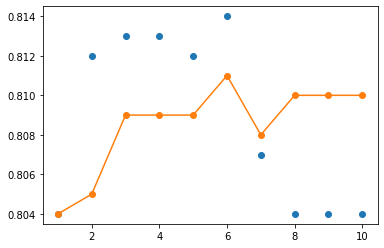

In [11]:
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
n_train = 100
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

n_members = 10
models = [FitModel(X_train, y_train) for _ in range(n_members)]
single_scores = []
ensemble_scores = []

for i in range(1, len(models) + 1):
  ensemble_score = EvaluateModels(models, i, X_test, y_test)
  y_test_encoded = to_categorical(y_test)
  _, single_score = models[i - 1].evaluate(X_test, y_test_encoded, verbose=0)
  ensemble_scores.append(ensemble_score)
  single_scores.append(single_score)
  print(f'> {i}: Single: {single_score}, Ensemble: {ensemble_score}')

print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
x_axis = [i for i in range(1, len(models) + 1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()